# Hands-on3 (Video Processing, Facial Landmark, Resp Tracking, and RPPG)
---


### NIM : 122140116
### PENGOLAHAN SINYAL DATA

---
#### TUGAS HANDONS 3

Melakukan percobaan dan melakukan pembahasan di bawah.

1. Berdasarkan apa yang telah kita coba mengenai metode pengambilan sinyal respirasi menggunakan mediapipe. Menggunakan video yang kalian ambil masing-masing pada tahap Pre-requisite modul ini. Lakukan proses pengambilan sinyal respirasi dan juga post-processingnya dalam menentukan laju pernafasan per menit.
<br><br>

2. Kita menggunakan banyak metode dalam melakukan proses pengambilan sinyal pernafasan ini seperti apa itu Lucas-Kanade Optical Flow, tetapi kita tidak cukup detail dalam membahasnya kali ini. Anggap diri kamu sebagai periset independen, lakukan riset mandiri dan jelaskan konsep-konsep dan step yang kamu gunakan sampai kamu bisa mendapatkan laju pernafasan pada video kamu, dan jangan lupa untuk membandingkan hasil data dari video kamu dengan metode ini.
<br><br>
---


#### Penyelesaian :

1. Tahap pertama yang dilakukan adalah Melakukan Setup Terlebih dahulu. Pertama mengaktifkan environment dengan menngunakan command ***conda activate handson***. Setelah itu menginstall beberapa modul seperti berikut.
<li> pip install mediapipe # For mediapipe framework
<li> pip install opencv-python # OpenCV
<li> pip install scipy # Signal processing
<li> pip install numpy # Numpy
<br><br>

Kemudian dilanjut dengan melakukan import depedency yang telah diinstal seperti pada **KODE 1**

---

In [ ]:
## KODE 1
## Import dependencies
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as signal

2. Tahap kedua adalah mengimport model yang telah disediakan (didownload), kemudian untuk bagian base_option membuat objek yang akan digunakan untuk MediaPipe (melakukan pendeteksi wajah) seperti pada **KODE 2**.  base_option untuk template model yang telah dideklarasikan. Pada intinya ini untuk konfigurasi model BlazeFace yang akan dilakukan ke video yang telah diambil (122140116.mp4).

---

In [ ]:
## KODE 2
## Create faceDetector Object

## Define the models
base_model="model/blaze_face_short_range.tflite"
base_options = python.BaseOptions(model_asset_path=base_model)

## Mediapipe configuration options
FaceDetectorOptions = vision.FaceDetectorOptions
VisionRunningMode = vision.RunningMode
options = FaceDetectorOptions(
    base_options=base_options,
    running_mode = VisionRunningMode.IMAGE,
)
face_detector = vision.FaceDetector.create_from_options(options)


3. Melakukan Proses POS (Plane-Orthogonal to Skin) dengan **KODE 3**. Mengambil input sinyal untuk array 3D.([e,c,f]), dengan menghitung panjang window 2 = 1.6 * fps. Terjadi Proses iterasi, dan temporal normalization, proyeksi, tuning sinyal, overlap-add, dan pengembalian output.Pada intinya POS ini untuk mengimplementasi algoritma POS untuk mengekstraksi rPPG dari video RGB. rPPG sendiri secara singkat adalah cara pengukuran detak jantung tanpa kontak fisik menggunakan kamera menggunakan perubahan warna kulit.

---


In [ ]:
## KODE 3
## Core method POS 
def POS(signal, **kargs):
    """
    POS method on CPU using Numpy.

    The dictionary parameters are: {'fps':float}.

    Wang, W., den Brinker, A. C., Stuijk, S., & de Haan, G. (2016). Algorithmic principles of remote PPG. IEEE Transactions on Biomedical Engineering, 64(7), 1479-1491. 
    """
    """
    eps: A small constant (10^-9) used to prevent division by zero in normalization steps.
    X: The input signal, which is a 3D array where:
    e: Number of estimators or regions in the frame (like different parts of the face).
    c: Color channels (3 for RGB).
    f: Number of frames.
    w: Window length, determined by the camera's frame rate (fps). For example, at 20 fps, w would be 32 (which corresponds to about 1.6 seconds of video).
    """
    eps = 10**-9
    X = signal
    e, c, f = X.shape # Number of estimators, color channels, and frames
    w = int(1.6 * kargs['fps']) # Window length in frames

    """
    P: A fixed 2x3 matrix used for the projection step. It defines how to transform the color channels (RGB) into a new space.
    Q: This is a stack of the matrix P repeated e times, where each P corresponds to an estimator (region of interest) in the video.
    """
    P = np.array([[0, 1, -1], [-2, 1, 1]])
    Q = np.stack([P for _ in range(e)], axis = 0)

    """
    H: A matrix to store the estimated heart rate signal over time for each estimator.
    n: The current frame in the sliding window.
    m: The start index of the sliding window (calculating which frames are part of the current window).
    """
    H = np.zeros((e, f))
    for n in np.arange(w, f):
        # Start index of sliding window 
        m = n - w + 1

        """
        Temporal Normalization (Equation 5 from the paper): This step ensures that the signal is invariant to global lighting changes and other noise factors.
        """
        Cn = X[:, :, m:(n+1)]
        M = 1.0 / (np.mean(Cn, axis = 2) + eps)
        M = np.expand_dims(M, axis=2) # shape [e, c, w]
        Cn = np.multiply(Cn, M)

        """
        Projection (Equation 6 from the paper): This step transforms the RGB values into a space where the signal from blood flow (heart rate) is more distinct.
        """
        S = np.dot(Q, Cn)
        S = S[0, :, :, :]
        S = np.swapaxes(S, 0, 1) 

        """
        Tuning (Equation 7 from the paper): This step adjusts the projected components to make the heart rate signal clearer.
        """
        S1 = S[:, 0, :]
        S2 = S[:, 1, :]
        alpha = np.std(S1, axis=1) / (eps + np.std(S2, axis=1))
        alpha - np.expand_dims(alpha, axis=1)
        Hn = np.add(S1, alpha * S2)
        Hnm = Hn - np.expand_dims(np.mean(Hn, axis=1), axis=1)

        """
        Overlap-Adding (Equation 8 from the paper): This step combines the processed signals from each frame to form the final output heart rate signal.
        """
        H[:, m:(n + 1)] = np.add(H[:, m:(n + 1)], Hnm)  # Add the tuned signal to the output matrix

    return H

4. Pada **KODE 4** di bawah ini menyiapkan menyiapkan variabel untuk ekstraksi sinyal warna dari wajah. r_signal, g_signal, dan b_signal menyimpan nilai RGB dari kulit. Dengan fps sebesar 35 dan durasi 60 detik, sistem memproses hingga 2100 frame yang disimpan dalam frame_buffer. Variabel margin_x dan scaling_factor digunakan untuk mengatur posisi dan ukuran area wajah yang dianalisis.

---

In [ ]:
## KODE 4
## Some variables, containers, constants and buffer
r_signal, g_signal, b_signal = [], [], [] ## For storing RGB value from the skin
fps = 35 ## Frame rate of the camera
time_window = 60 # Time window in seconds
frame_buffer_limit = time_window * fps ## Number of frames to be processed, since toby-rgb is 60 seconds
frame_buffer = [] ## Buffer for storing frames
margin_x = 10  # Adjust horizontally
scaling_factor = 0.8 # Scaling factor for the bounding box

5. Berikut ini adalah proses POS untuk video sample yang telah diambil (media/122140116.mp4). Langkah awal adalah mengambil path video, dan melakukan pembacaan frame video selama 60 detik. Selanjutnya melakukan konversi warna video ke RGB. Kemudian melakukan pendeteksian wajah, dan proses ekstraksi ROI dari bounding box wajah. Kemudian mengambil nilai rata-rata RGB untuk ketiga warna. Diakhiri dengan menampilkan visualisasi grafik sintal RGB seperti berikut.

---


Error: Could not read frame.


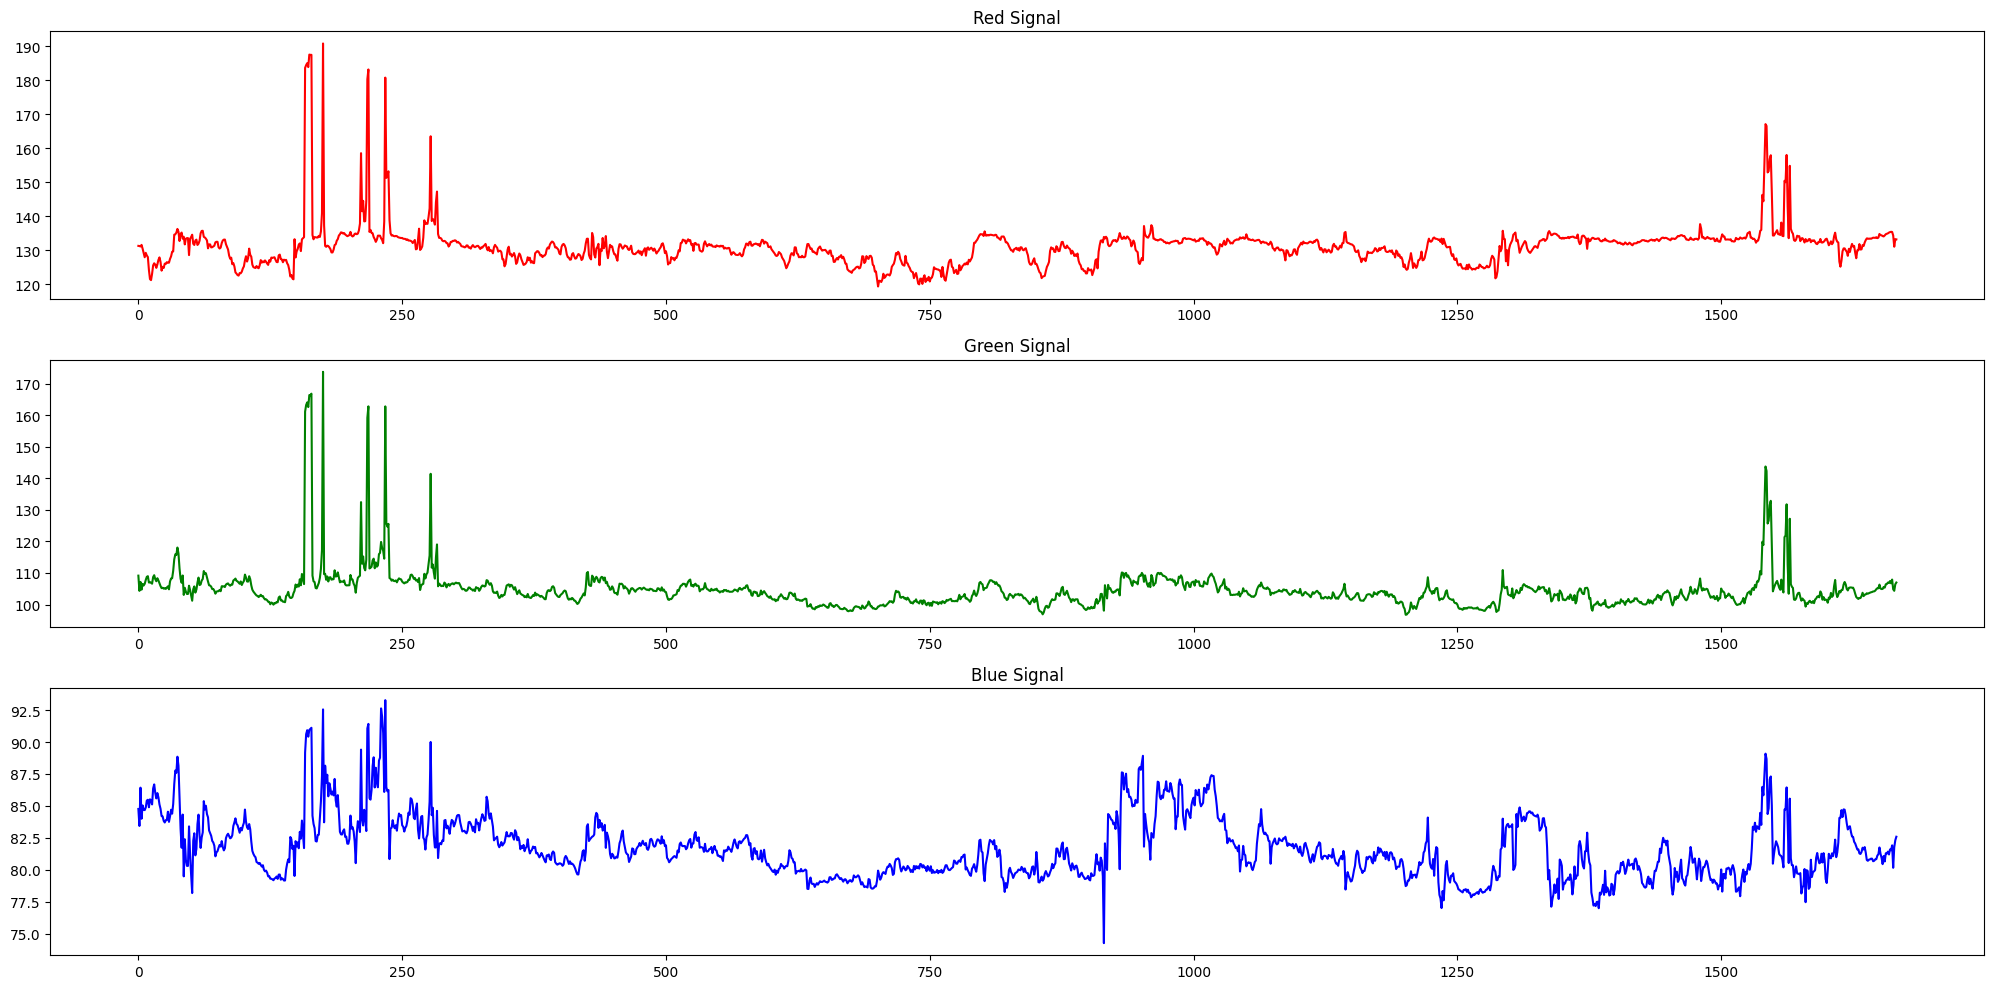

In [ ]:
## KODE 5
try:
    ## Load the Video
    file_path = os.path.join("media/122140116.mp4") ## Path to the video file
    
    ## Put 0 to use the camera, or use the video file path for analyzing a video
    cap = cv2.VideoCapture(file_path) 

    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    ## Untuk mendapatkan 60 detik video.
    while len(frame_buffer) < frame_buffer_limit:

        ## Read the frame from the camera
        ret, frame = cap.read() 
        if not ret:
            print("Error: Could not read frame.")
            break

        ## Adding the frame_buffer to the list
        frame_buffer.append(frame)


        ## Convert the frame to RGB
        ## Karena default dari OpenCV adalah BGR, kita perlu mengkonversi ke RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        ## Seting up the Mediapipe Image
        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=rgb_frame
        )

        ## Process the frame using the face detector
        result = face_detector.detect(mp_image)

        """
        Where the magic happens:

        Proses ini melakukan deteksi wajah pada frame video untuk mendapatkan bounding box wajah.
        Kemudian, bounding box ini digunakan untuk mendapatkan ROI (Region of Interest) dari wajah, yang kemudian digunakan 
        untuk menghitung nilai rata-rata RGB dari area tersebut. 

        Nilai rata-rata RGB ini disimpan dalam list r_signal, g_signal, dan b_signal untuk analisis lebih lanjut.
        """

        if result.detections:
            for detection in result.detections:

                ## Get the Bounding box
                bboxC = detection.bounding_box
                x, y, w, h = bboxC.origin_x, bboxC.origin_y, bboxC.width, bboxC.height

                ## Setup tipis tipis biar boxnya pas di tengah wajah
                new_x = int(x + margin_x)
                new_w = int(w * scaling_factor)
                new_h = int(h * scaling_factor)

                ## Get the ROI
                face_roi = rgb_frame[y:y+new_h, new_x:new_x+new_w]
            
                ## Draw the bounding box on the frame
                cv2.rectangle(frame, (int(x), int(y)), (int(x + new_w), int(y + new_h)), (0, 255, 0), 2)

                ## Calculate the Mean RGB values of the face ROI
                mean_rgb = cv2.mean(face_roi)[:3]
                
                # Append the combined RGB values to the respective lists
                r_signal.append(mean_rgb[0])
                g_signal.append(mean_rgb[1])
                b_signal.append(mean_rgb[2])

        # Show the frame
        cv2.imshow("frame", frame) 

        # Check if 'q' is pressed or the window is closed
        if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("frame", cv2.WND_PROP_VISIBLE) < 1:
            break

except Exception as e:
    print(f"An error occurred: {e}")
    cap.release()
    cv2.destroyAllWindows()

finally:
    ## Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()

    ax, fig = plt.subplots(3, 1, figsize=(20, 10))
    fig[0].plot(r_signal, color='red')
    fig[0].set_title('Red Signal')
    fig[1].plot(g_signal, color='green')
    fig[1].set_title('Green Signal')
    fig[2].plot(b_signal, color='blue')
    fig[2].set_title('Blue Signal')
    plt.tight_layout()
    plt.show()

---

Dari grafik di atas terdapat 2 garis, dimana garis sumbu X (horizontal) menunjukkan jumlah frame. Pada konteks tugas ini menggunakan video dengan 30 fps, dikarenakan 60 detik total durasi maka total frame 1800. Untuk sumbu y merupakan channel warna r_signal, g_signal, b_signal yang menggunakan rumus mean_rgb = cv2.mean(face_roi) dengan menghitung rata-rata nilai bounding vox wajah (face_roi).
Pada penerapan POS ini terdapat 3 warna, dimana sinyal merah menghasilkan intesitas warna pada wajah, jika sinyal memiliki fluktuasi kecil menunjukkan perubahan aliran darah di bawah kulit.
Jika terjadi lonjakan sinyal artinya terjadi aliran darah disebabkan oleh pergerakan kepala, ataupun perubahan cahaya.
Sinyal hijau memiliki informasi yang terkait rPPG, karena hijau sangat sensitif pada perubahan volume darah di kulit. Perubahan sinyal diproses mengestimasi detak jantung. Begitu juga dengan sinyal biru.

---

6. Penjelasan **KODE 6**, kode berikut menghitung sinyal dengan menyusun ulang RGB ke dalam array NumPy 3D, memanggil POS untuk menghitung sinyal dan meratakan sinyal hasil POS. Diakhiri dengan menampilkan grafik berwarna hitam.

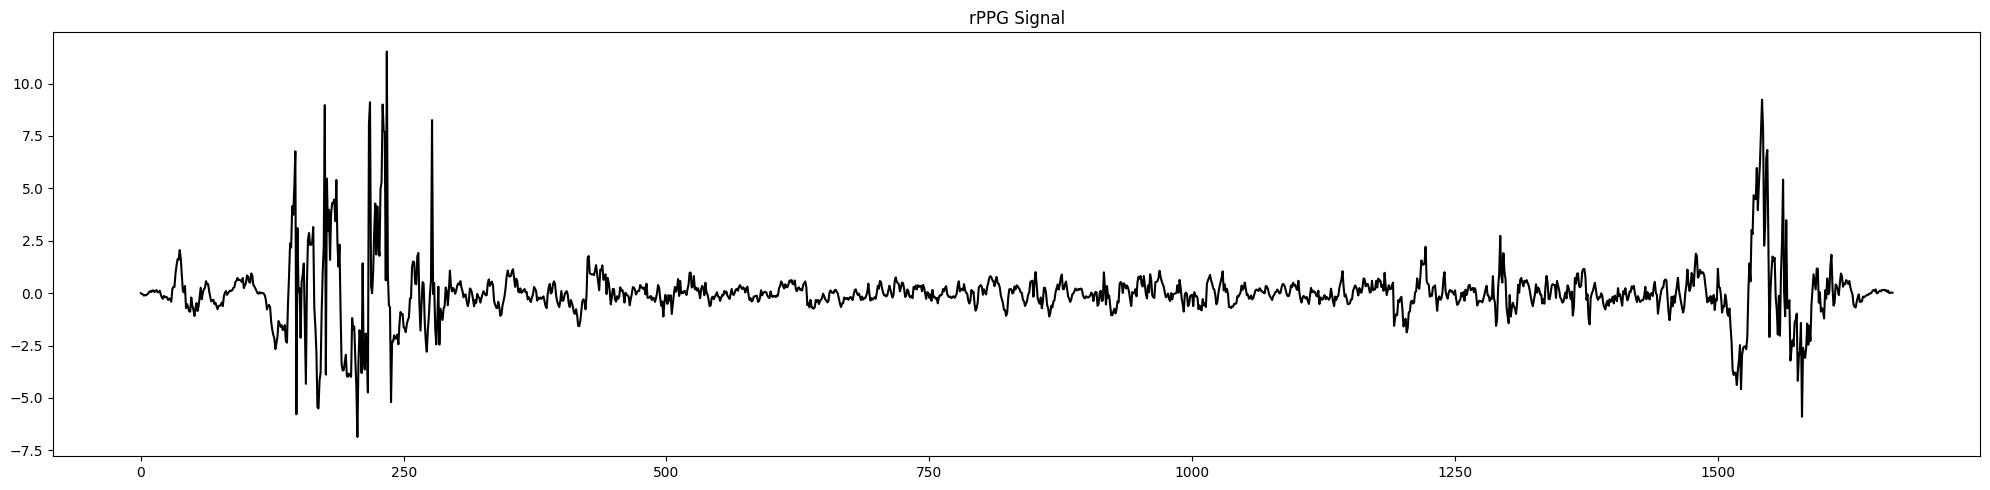

In [ ]:
## KODE 6
# Menghitung rPPG menggunakan Metode POS
rgb_signals = np.array([r_signal, g_signal, b_signal])
rgb_signals = rgb_signals.reshape(1, 3, -1)
rppg_signal = POS(rgb_signals, fps=30)
rppg_signal = rppg_signal.reshape(-1)

# 6.1 Menampilkan grafik Sinyal rPPG
plt.figure(figsize=(20, 5))
plt.plot(rppg_signal, color='black')
plt.title('rPPG Signal')
plt.tight_layout()
plt.show()

Setelah sinyal warna wajah (merah, hijau, biru) dikumpulkan selama pemrosesan video, kode ini menggunakan metode POS (Plane-Orthogonal-to-Skin) untuk mengekstrak sinyal rPPG, yaitu sinyal denyut jantung yang diperoleh secara non-kontak hanya dari video wajah. Pertama, sinyal RGB dari wajah disusun ulang dalam array tiga dimensi dengan format [1, 3, jumlah_frame], sesuai dengan format input yang diharapkan oleh algoritma POS. Kemudian, fungsi POS() dipanggil dengan data RGB tersebut dan parameter fps=30 (frame per second) untuk menghitung sinyal rPPG. Hasil sinyal ini direpresentasikan sebagai array satu dimensi (reshape(-1)) yang menggambarkan fluktuasi volume darah secara periodik berdasarkan perubahan warna di wajah. Terakhir, sinyal ini diplot menggunakan matplotlib, menghasilkan grafik garis hitam yang menunjukkan variasi sinyal rPPG terhadap waktu (frame), yang dapat digunakan untuk analisis lebih lanjut seperti deteksi detak jantung. Pada intinya sinyal di atas adalah representasi dari 3 sinyal RGB yan telah diolah.

---

7. Tahap berikut ini adalah Post Processing yang dilakukan pada **KODE 7**.
Grafik yang ditampilkan merupakan hasil analisis sinyal RGB (merah, hijau, biru) dari wajah seseorang yang terekam dalam video. Analisis ini digunakan dalam metode bernama remote Photoplethysmography (rPPG), yaitu teknik pengukuran detak jantung secara non-kontak hanya melalui kamera. Sumbu X pada grafik mewakili waktu dalam satuan frame (misalnya, 30 frame per detik jika video direkam pada 30 fps), sedangkan sumbu Y menunjukkan rata-rata intensitas warna pada wajah. Perubahan kecil pada warna kulit yang tertangkap kamera diakibatkan oleh perubahan volume darah saat jantung berdetak. Sinyal warna hijau biasanya paling akurat dalam merefleksikan perubahan ini karena hemoglobin menyerap cahaya hijau lebih kuat. Dengan kata lain, gelombang-gelombang yang terlihat dalam grafik mencerminkan fluktuasi denyut jantung. Jika sinyalnya stabil dan ritmis, hal itu menunjukkan bahwa wajah terdeteksi dengan baik dan denyut jantung dapat dipantau secara visual. Sebaliknya, lonjakan acak atau sinyal yang tidak beraturan bisa jadi disebabkan oleh gerakan wajah atau pencahayaan yang tidak stabil. Grafik ini berguna sebagai dasar untuk menghitung detak jantung per menit (BPM) menggunakan teknik lanjutan seperti Fast Fourier Transform (FFT).

---


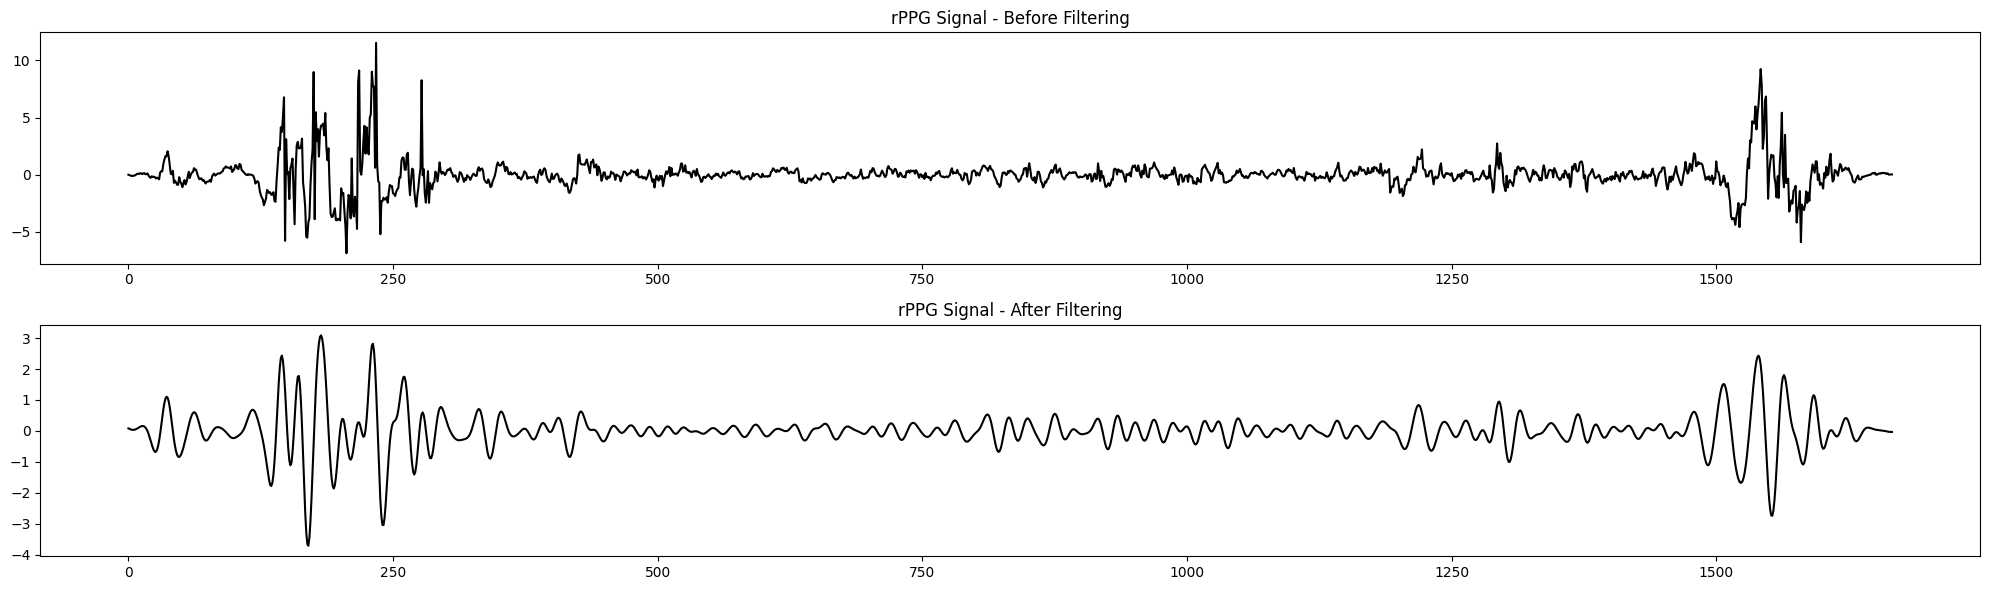

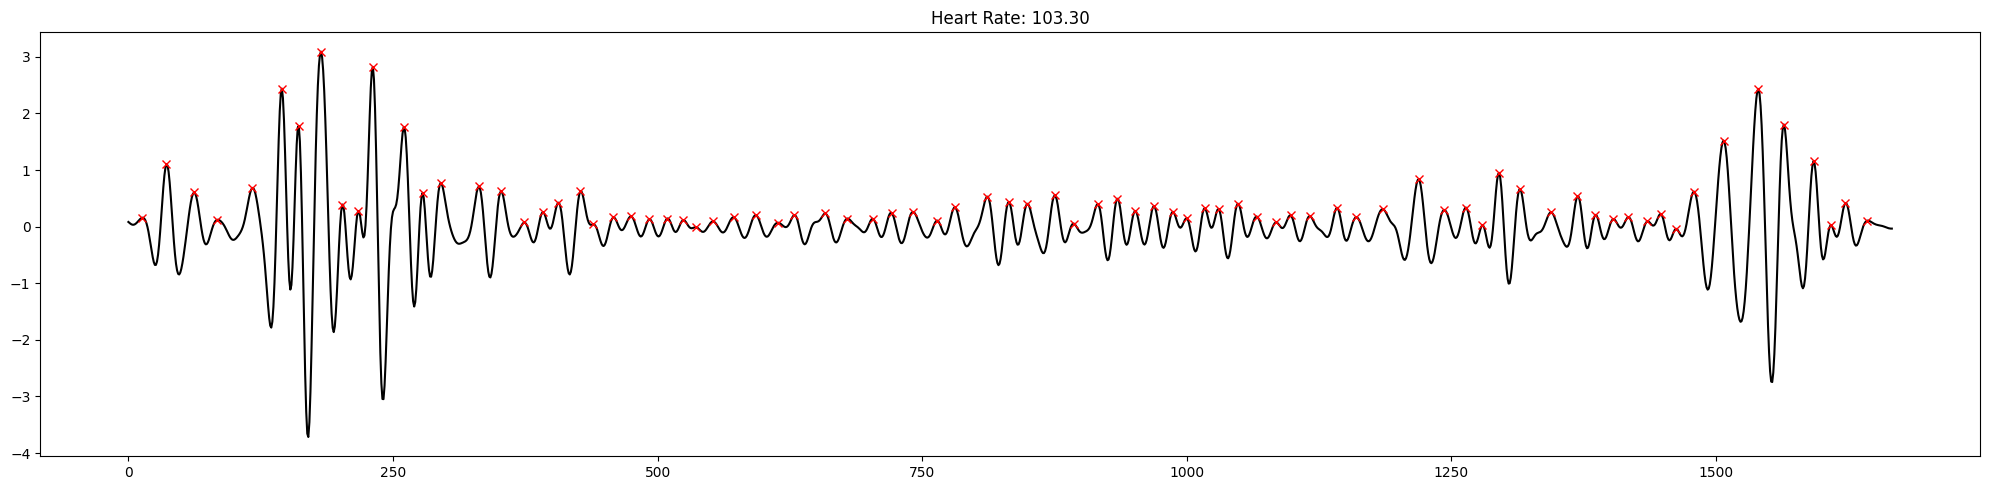

In [ ]:
## KODE 7
# Memfilter Sinyal rPPG
fs = 35; lowcut = 0.9; highcut = 2.4; order = 3
b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
filtered_rppg = signal.filtfilt(b, a, rppg_signal)

fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(rppg_signal, color='black')
ax[0].set_title('rPPG Signal - Before Filtering')
ax[1].plot(filtered_rppg, color='black')
ax[1].set_title('rPPG Signal - After Filtering')
plt.tight_layout()
plt.show()

# Mencari puncak sinyal
peaks, _ = signal.find_peaks(
    x=filtered_rppg,
)

# Menghitung heart rate
heart_rate = 60 * len(peaks) / (len(filtered_rppg) / fs)

# Menampilkan grafik puncak sinyal
plt.figure(figsize=(20, 5))
plt.plot(filtered_rppg, color='black')
plt.plot(peaks, filtered_rppg[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

Grafik ini menggambarkan tahapan pemrosesan sinyal rPPG (remote photoplethysmography) yang diperoleh dari video wajah, dengan tujuan untuk memperkirakan detak jantung seseorang. Pada panel pertama, terlihat sinyal sebelum dilakukan penyaringan (filtering).  Sinyal masih mengandung banyak noise, fluktuasi tinggi, dan artefak yang tidak teratur akibat gangguan pencahayaan, gerakan wajah, atau variabilitas RGB yang tidak stabil. Bentuk gelombangnya belum jelas mencerminkan pola detak jantung.

Panel kedua menunjukkan sinyal setelah melalui proses filtering, di mana hanya komponen frekuensi yang relevan dengan denyut jantung yang dipertahankan. Hasilnya, sinyal tampak lebih bersih dan menampilkan pola gelombang yang lebih stabil dan berulang, mencerminkan aktivitas detak jantung yang sebenarnya. 

Pada panel ketiga, sinyal yang telah difilter digunakan untuk mendeteksi puncak-puncak gelombang, yang ditandai dengan titik merah. Puncak-puncak ini merepresentasikan tiap denyut jantung yang berhasil dikenali, dan berdasarkan interval antar puncak, diperoleh estimasi detak jantung sebesar 103,30 bpm. Secara keseluruhan, grafik ini memperlihatkan bagaimana proses filtering berperan penting dalam mengekstrak sinyal fisiologis yang berguna dari data mentah yang penuh gangguan.

Sehingga kesimpulan yang diambil proses filtering sangat efektif dalam menyaring noise dan memperjelas sinyal denyut jantung dari hasil rPPG mentah, sehingga lebih siap digunakan untuk deteksi puncak dan perhitungan heart rate secara akurat.

---

8. Penggunaan Landmark pada **KODE 8** untuk melihat pergerakan bahu dari video sample. Langkah pertama adalah melakukan setup variabel dan lainnya seperti di bawah. Basis model yang digunakan adalah metode optical flow. Variabel seperti resp_signal untuk menyimpan sinyal respirasi, fps dan time_window untuk menentukan jumlah frame yang akan dianalisis (selama 60 detik), serta frame_buffer untuk menyimpan frame video. Selain itu, disiapkan pula variabel-variabel untuk optical flow seperti parameter Lucas-Kanade (lk_params), frame sebelumnya dalam grayscale (old_gray), dan koordinat ROI (Region of Interest) tempat pergerakan akan dianalisis. Ukuran standar frame juga diatur ke 640x480 piksel.

---

In [ ]:
## KODE 8
## Setup variables, constants and etc..
resp_signal = []
fps = 35 ## Frame rate of the camera
time_window = 60 # Time window in seconds
frame_buffer_limit = time_window * fps ## Number of frames to be processed, since toby-rgb is 60 seconds
frame_buffer = [] ## Buffer for storing frames
features = None # for storing the features optical flow.
lk_params = None ## Lucas-Kanade parameters
old_gray = None ## Old gray frame
left_x, top_y, right_x, bottom_y = None, None, None, None ## Coordinates for the ROI
STANDARD_SIZE = (640, 480)  # Pick whatever size you want

9. Langkah berikutnya adalah membangun model template dari pose_landmark.task. **Kode 9** pernapasan (respirasi) berbasis video dengan cara melacak pergerakan bahu seseorang dari frame ke frame menggunakan deteksi pose dan optical flow. Sebelum analisis dimulai, beberapa variabel dan konstanta diatur, seperti fps (frame per detik), time_window (durasi video yang diamati), serta frame_buffer untuk menyimpan frame selama 60 detik.

Selanjutnya, dibuatlah pose detector dari model MediaPipe (pose_landmarker.task) yang mampu mendeteksi titik-titik pose tubuh manusia dari gambar. Kemudian, didefinisikan fungsi get_initial_roi, yang bertugas menemukan region of interest (ROI) pertama berdasarkan posisi bahu kiri dan kanan yang dideteksi dari video. Fungsi ini menghitung titik tengah antara dua bahu sebagai acuan untuk membuat ROI (area persegi panjang di sekitar dada/torso) dengan dimensi yang bisa diatur (x_size, y_size) dan bisa digeser dengan parameter shift_x dan shift_y untuk lebih fokus ke area dada yang bergerak saat bernapas.

Dengan ROI ini, sistem nantinya akan menggunakan metode pelacakan gerak (optical flow) untuk mengamati pergerakan vertikal area dada atau bahu yang berkaitan dengan naik-turunnya napas. Hasil pergerakan ini akan disimpan dalam array resp_signal untuk dianalisis sebagai sinyal respirasi.

---

In [ ]:
## KODE 9
## Create Pose Landmarker Object

## Define the models
model_path = "model/pose_landmarker.task"
BaseOptions = mp.tasks.BaseOptions

PoseLandmarkerOptions = vision.PoseLandmarkerOptions
VisionRunningMode = vision.RunningMode

options_image = PoseLandmarkerOptions(
    base_options=BaseOptions(
        model_asset_path=model_path,
    ),
    running_mode=VisionRunningMode.IMAGE,
    num_poses=1,
    min_pose_detection_confidence=0.5,
    min_pose_presence_confidence=0.5,
    min_tracking_confidence=0.5,
    output_segmentation_masks=False
)

pose_landmarker = vision.PoseLandmarker.create_from_options(options_image)

10. Berikut ini adalah kode untuk meng-capture bagian area awal yaitu bahu ata dada yang akan digunakan untuk tracking gerakan nafas dalam metode optical flow. Proses dimulai dari konversi warna video, menentukan ukuran video, membuat objek mediapipe, mendeteksi pose, dan validasi titik tengah, memberikan batas ROI, dan mengembalikan koordinat ROI.
<br><br>
---

In [ ]:
## KODE 10
# Function to get the Initial ROI for Tracking with Optical Flow
def get_initial_roi(image, landmarker, x_size = 100, y_size=100, shift_x=0, shift_y=0):
    """
    Mendapatkan ROI awal berdasarkan posisi bahu menggunakan pose detection.
    Args:
        image: Frame video input
        landmarker: Model pose detector
        x_size: Jarak piksel dari titik tengah ke tepi kiri/kanan
        y_size: Jarak piksel dari titik tengah ke tepi atas/bawah
        shift_x: Pergeseran horizontal kotak (negatif=kiri, positif=kanan)
        shift_y: Pergeseran vertikal kotak (negatif=atas, positif=bawah)
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    ## Create Mediapipe image
    mp_image = mp.Image(
        image_format = mp.ImageFormat.SRGB,
        data = image_rgb
    )

    ## Inference Detect Landmarks
    detection_result = landmarker.detect(mp_image)

    if not detection_result.pose_landmarks:
        raise ValueError("No pose detected in the frame")
    
    landmarks = detection_result.pose_landmarks[0]

    ## Get should position from the landmarks
    left_shoulder = landmarks[11]
    right_shoulder = landmarks[12]

    ## Calculate the center point between should before creating the ROI Bounds
    center_x = int((left_shoulder.x + right_shoulder.x) * width / 2)
    center_y = int((left_shoulder.y + right_shoulder.y) * height / 2)

    ## Apply shift to the center point (offset from the chest)
    center_x += shift_x
    center_y += shift_y

    ## Create the ROI Bounds from the center point and sizes
    left_x = max(0, center_x - x_size)
    right_x = min(width, center_x + x_size)
    top_y = max(0, center_y - y_size)
    bottom_y = min(height, center_y)

    ## Validate ROI size
    if (right_x - left_x) <= 0 or (bottom_y - top_y) <= 0:
        raise ValueError("Invalid ROI dimensions")
    
    ## Return top, left, bottom, right points
    return (left_x, top_y, right_x, bottom_y)

11. Pada kode berikut terdiri dari proses fungsi initialize_features untuk inisiasi ftur guna optical flow. Menggunakan fungsi get_initial _rou untuk menentukan roi (Dada), setelah itu diubah ke grayscale kemudian dideteksi titik sudut menggunakan *cv2.goodFeaturesToTrack*. Gerakan-gerakan ini divisualisasikan dengan menggambar garis dan titik di frame, dan rata-rata pergerakan vertikal (koordinat y) dari titik-titik tersebut dihitung sebagai sinyal respirasi. Nilai-nilai ini disimpan dalam daftar resp_signal untuk kemudian divisualisasikan sebagai grafik. Bounding box juga ditampilkan di sekitar area pelacakan, dan pengguna dapat melihat visualisasi proses secara real-time melalui jendela video. Jika fitur pelacakan tidak lagi cukup (kurang dari 10 titik), maka deteksi ulang dilakukan. Setelah pemrosesan selesai, grafik sinyal pernapasan ditampilkan dengan sumbu X merepresentasikan waktu (dalam satuan frame) dan sumbu Y menunjukkan pergerakan vertikal yang diasosiasikan dengan siklus pernapasan seseorang. Teknik ini berguna dalam pemantauan fisiologis non-invasif, terutama dalam situasi di mana sensor fisik tidak memungkinkan untuk digunakan.
Berikutnya akan diletakkan titik roi ini ke dalam frame penuh.

---

In [ ]:
## KODE 11
def initialize_features(frame):
    """
    Metode untuk mendapatkan nilai features untuk keperluan optical flow dan membuat object Lucas Kanade sebagai argument dari optical flow itu sendiri.
    frame: cv2Object = frame sumber dari kamera untuk melakukan deteksi ROI dada dan bahu
    """
    
    global features, lk_params, old_gray, left_x, top_y, right_x, bottom_y, STANDARD_SIZE   # Declare them as global to modify the outer variables

    roi_coords = get_initial_roi(frame, pose_landmarker)
    left_x, top_y, right_x, bottom_y = roi_coords
    
    frame = cv2.resize(frame, STANDARD_SIZE)
    old_frame = frame.copy()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    roi_chest = old_gray[top_y:bottom_y, left_x:right_x]
    features = cv2.goodFeaturesToTrack(roi_chest, maxCorners=50, qualityLevel=0.2, minDistance=5, blockSize=3)
    if features is None:
        raise ValueError("No features found to track!")
    features = np.float32(features)
    features[:,:,0] += left_x
    features[:,:,1] += top_y
    old_gray = old_gray
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

12.  Proses mengubah data pada video menggunakan model yang telah dibangun. Pada video akan dideteksi frame per frame dalam satuan detik (akan muncul popup). Kemudian roi dada akan di tandai dan memberikan visual perpindahan titik roi tersebut ke dalam grafik di bawah.

Error: Could not read frame.


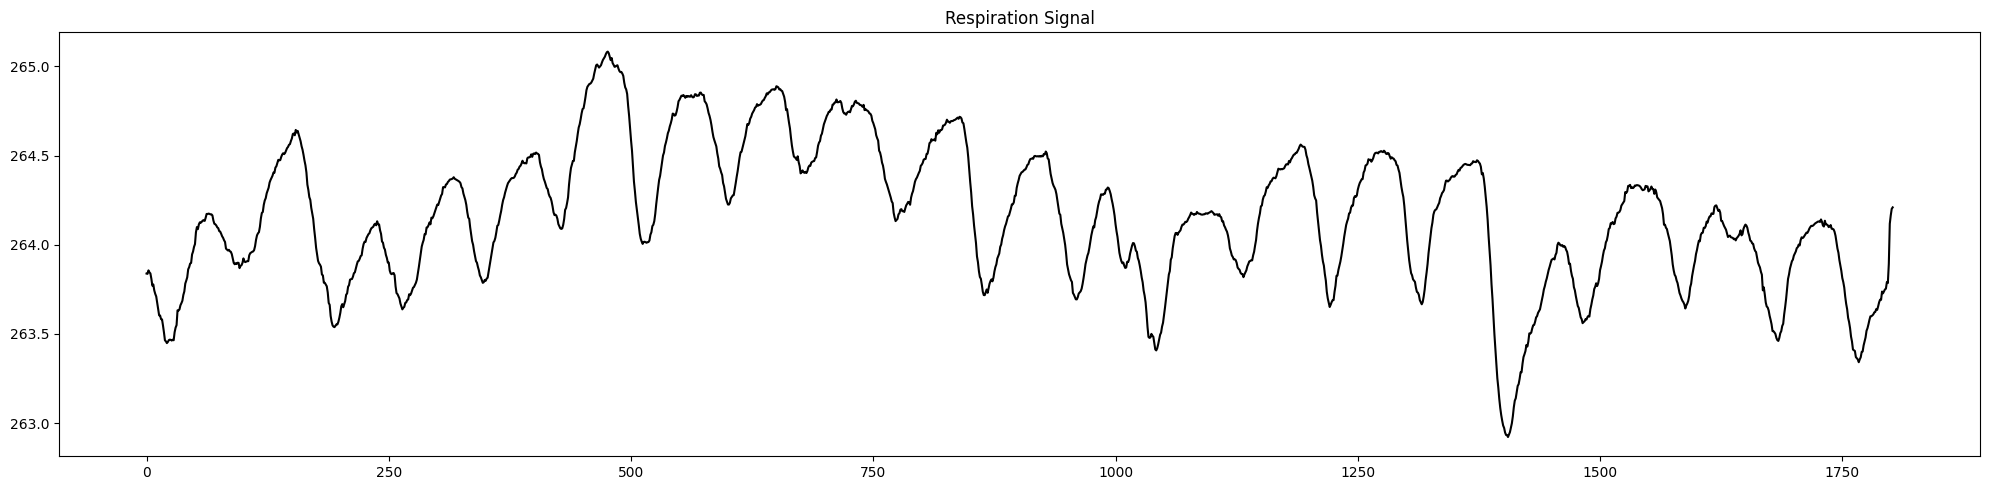

In [ ]:
## KODE 12
try:
    ## Load the Video
    file_path = os.path.join("media/122140116.mp4") ## Path to the video file
    
    ## Put 0 to use the camera, or use the video file path for analyzing a video
    cap = cv2.VideoCapture(file_path) 

    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    ## Untuk mendapatkan 60 detik video.
    while len(frame_buffer) < frame_buffer_limit:

        ## Read the frame from the camera
        ret, frame = cap.read() 
        if not ret:
            print("Error: Could not read frame.")
            break

        frame = cv2.resize(frame, STANDARD_SIZE)
        ## Adding the frame_buffer to the list
        frame_buffer.append(frame)

        if features is None:
            # Initialize ROI and feature detection
            initialize_features(frame)

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if len(features) > 10:
            new_features, status, error = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, features, None, **lk_params)
            good_old = features[status == 1]
            good_new = new_features[status == 1]
            mask = np.zeros_like(frame)
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                frame = cv2.circle(frame, (int(a), int(b)), 3, (0, 255, 0), -1)
            frame = cv2.add(frame, mask)
            if len(good_new) > 0:
                avg_y = np.mean(good_new[:, 1])
                resp_signal.append(avg_y)
                features = good_new.reshape(-1, 1, 2)
            old_gray = frame_gray.copy()
        else:
            # Reinitialize features if tracking fails
            initialize_features(frame)

        ## Plot bounding box
        cv2.rectangle(frame, (int(left_x), int(top_y)), (int(right_x), int(bottom_y)), (0, 255, 0), 2)
        
        # Show the frame
        cv2.imshow("frame", frame) 

        # Check if 'q' is pressed or the window is closed
        if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("frame", cv2.WND_PROP_VISIBLE) < 1:
            break

except Exception as e:
    print(f"An error occurred: {e}")
    cap.release()
    cv2.destroyAllWindows()

finally:
    ## Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()
    
    ## Plot the Respiration Signal
    plt.figure(figsize=(20, 5))
    plt.plot(resp_signal, color='black')
    plt.title('Respiration Signal')
    plt.tight_layout()
    plt.show()

Grafik di atas adalah grafik sinyal pernapasan titik roi dada selama semenit. Sumbu horizontal menunjukkan waktu dalam indeks frame, sedangan vertikal menunjukkan posisi vertikal rata rata fitur roi dada. Sinyal naik turun ini menampilkan tarikan napas (Dada naik), sedangkan sinyal turun menunjukkan respirasi mengehembuskan napas (dada turun menghembus napas). Didapat hasil gelombang naik turunnya adalh 21,5 gelombang. Yang dapat diartikan 21,5 bpm atau 21,5 napas/menit.

---

Dari percobaan saat melakukan take selama 60 detik dan pencatatan waktu penghembusan napas secara paralel, didapat data waktu pernapasan (durasipenghembusannapas.csv) sebagai berikut :
Ini adalah tabel setelah di konversi menjadi rentang waktu penhembusan nafas.

| Nafas Ke- | Second | Milisecond |
|-----------|--------|------------|
| 1         | 0.00   | 0          |
| 2         | 2.30   | 2300       |
| 3         | 5.11   | 5110       |
| 4         | 7.66   | 7660       |
| 5         | 10.32  | 10320      |
| 6         | 13.21  | 13210      |
| 7         | 15.58  | 15580      |
| 8         | 18.38  | 18380      |
| 9         | 21.34  | 21340      |
| 10        | 24.10  | 24100      |
| 11        | 27.34  | 27340      |
| 12        | 30.31  | 30310      |
| 13        | 33.21  | 33210      |
| 14        | 36.09  | 36090      |
| 15        | 42.25  | 42250      |
| 16        | 45.21  | 45210      |
| 17        | 48.02  | 48020      |
| 18        | 51.02  | 51020      |
| 19        | 54.53  | 54530      |
| 20        | 57.41  | 57410      |
| 21        | 60.31  | 60310      |

Untuk berikut ini tabel awal data stopwatch yang memiliki total 63 detik sekian karena lebih dalam pengambilan durasi.

| Nafas Ke- | Waktu Putaran (menit detik,milidetik) |
|-----------|----------------------------------------|
| 1         | 00:02,30                               |
| 2         | 00:02,81                               |
| 3         | 00:02,55                               |
| 4         | 00:02,66                               |
| 5         | 00:02,89                               |
| 6         | 00:02,37                               |
| 7         | 00:02,80                               |
| 8         | 00:02,96                               |
| 9         | 00:02,76                               |
| 10        | 00:03,24                               |
| 11        | 00:02,97                               |
| 12        | 00:02,90                               |
| 13        | 00:02,88                               |
| 14        | 00:06,16                               |
| 15        | 00:02,96                               |
| 16        | 00:02,81                               |
| 17        | 00:03,00                               |
| 18        | 00:03,51                               |
| 19        | 00:02,88                               |
| 20        | 00:02,90                               |
| 21        | 00:03,38                               |

Jika melihat rumus heart rate (HR) 1 siklus napas = 1 menghirup napas dan pelepasan napas. Dalam konteks data yang saya ambil saya mendapatkan 21 kali pernapasan dengan durasi 63,69 detik. Jika menggunakan rumus RR (BPM) = (jumlah napas / durasi) x 60
RR = (21 / 63,69) X 60 = 19,8 napas/menit.
 
Dari referensi yang saya ambil frekuensi napas lakilaki dewasa 16-18 kali. Dan heart rate usia 16 tahun keatas 60-100. Saya mengasumsi perbandingan RR : HR = 18 : 100 = 1 : 5.56. Sehingga dari asumsi tersebut saya mengambil RR saya yaitu 19.8 dikali 5,56 hasilnya 110. Sehingga dari percobaan perhitungan durasi pernapasan mendapatkan hasil Heart Rate 110. Jika dilihat dari percobaan memlakukan rPPG menggunakan metode POS hasil dari Heart rate adalah 103.30. Didapat hasil dari perhitungan manual dengan percobaan POS = 110 : 103,30. Kemudian untuk metode Lucas Kanade didapat 20.5 * 5.56 = 113,98 atau 114. Sehingga perbandingan ketiganya manual : POS (rPPG) : L-K = 110 : 103.3 : 114.

Dari percobaan POS (rPPG) dan LUCAS-KANADE didapatkan perbedaan prinsip POS mendeteksi kulit wajah sedangkan L-K piksel area dada untuk deteksi pernapasan. Untuk sumber sinyal POS(rPPG) dari rgb area wajah, sedangkan L-K dari titik ROI dada. Untuk sinyal yang diambil POS adalah sinyal denyut jantung, sedangkan L-K sinyal pernapasan. Untuk pos agak sensitif dari noise cahaya dan gerakan wajah, sedangkan L-K lebih stabil karena mengambil sinyal naik turun dada.

---




## Lampiran

Referensi :

<unli> https://github.com/informatika-itera/if3024-handson/blob/main/2025-notebooks/7_hands-on3.ipynb

<unli> https://www.scribd.com/document/351677198/HR-RR-BP-Normal

<unli> https://chatgpt.com/share/6828a808-dd00-8009-afaa-39c1ef59265c

<unli> https://chatgpt.com/share/6828704c-e570-8009-8a8b-9b7d544f85c0

<br><br>
Github Repository Tugas: